In [26]:
import numpy as np
import pandas as pd
import deeptrack as dt
import matplotlib.pyplot as plt
from deeptrack.models.gnns.generators import GraphGenerator
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider
from dataset import Matlab
from IPython.display import clear_output
import scienceplots

In [27]:
class MAGIK():

    def __init__(self):

        self.weigths_path = os.getcwd()+"/MAGIK.h5"
        self.spat_temp_res = 3
        self.th = 1
        self.dataframe = None
        self.data_shape = (1,800,750)

    def load_dataframe(self, path):

        # Load a dataframe from path
        # centroid-0 is assumed to be x position and centroid-1 to be y position

        self.dataframe = pd.read_csv(path)
        self.dataframe['centroid-0'] /= self.data_shape[2]
        self.dataframe['centroid-1'] /= self.data_shape[1]

    def set_dataset(self, dataset):

        # Set dataset that is used for showing detections

        self.dataset = dataset

    def load_network(self, weigths_path):

        # Load pre-trained MAGIK network from weigths_path

        self._OUTPUT_TYPE = 'edges'
        self.radius = 0.03
        self.nofframes = 4
        
        self.model = dt.models.gnns.MAGIK(
            dense_layer_dimensions=(64, 96,),      # number of features in each dense encoder layer
            base_layer_dimensions=(96, 96, 96),    # Latent dimension throughout the message passing layers
            number_of_node_features=2,             # Number of node features in the graphs
            number_of_edge_features=1,             # Number of edge features in the graphs
            number_of_edge_outputs=1,              # Number of predicted features
            edge_output_activation="sigmoid",      # Activation function for the output layer
            output_type=self._OUTPUT_TYPE,              # Output type. Either "edges", "nodes", or "graph"
        )
        
        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'binary_crossentropy',
            metrics=['accuracy'],
        )
        self.model.load_weights(weigths_path)
    
    def create_nodes(self, spat_temp_res):

        # Create nodes with a spatio temporal resolution of spat_temp_res

        variables = dt.DummyFeature(
            radius=self.radius,
            output_type=self._OUTPUT_TYPE,
            nofframes=spat_temp_res, # time window to associate nodes (in frames) 
        )
        
        
        pred, gt, scores, graph = dt.models.gnns.get_predictions(
            self.dataframe, ["centroid"], self.model, **variables.properties()
        )

        self.edges_df, self.nodes, _ = dt.models.gnns.df_from_results(pred, gt, scores, graph)

    def create_trajectories(self, th):

        # Create trajectories with a threshold of th

        self.traj = dt.models.gnns.get_traj(self.edges_df, th=th)

    def setup(self, **kwargs):

        # Setup the nodes, edges and trajectories

        self.load_network(kwargs.get('weigths_path', self.weigths_path))
        self.create_nodes(kwargs.get('spat_time_res', self.spat_temp_res))
        self.create_trajectories(kwargs.get('th', self.th))
        if kwargs.get('clear', True):
            clear_output()

    def detect(self, dataset_frames=(0,10), setup=False, **kwargs):

        # Plot the detections and trajectories from MAGIK
        # Note again that centroid-0 is assumed to be the x position and centroid-1 the y position 

        if not hasattr(self, 'traj') or setup:
            self.setup(**kwargs)
        f=dataset_frames[0]
        for frame in self.dataset[dataset_frames[0]:dataset_frames[1]]:
        
            fig = plt.figure()
            plt.imshow(frame.squeeze(), cmap='gray')
            plt.text(10, 40, "Bild: " + str(f), fontsize=20, c="white")
            plt.axis("off")

            for i, (t, c) in enumerate(self.traj):
                detections = self.nodes[t][(self.nodes[t, 0] <= f) & (self.nodes[t, 0] >= f - 20), :]

                if (len(detections) == 0) or (np.max(self.nodes[t, 0]) < f):
                    continue
                
                plt.plot(detections[:, 1] * self.data_shape[2], detections[:, 2] * self.data_shape[1], color = c, linewidth=2)
                plt.scatter(detections[-1, 1] * self.data_shape[2], detections[-1, 2] * self.data_shape[1], linewidths=1.5, c = c)
                
            f += 1
            plt.show()

In [29]:
dataframe_path = r"C:\Users\kelme\Desktop\Deep_Learning\DeepLearningParticleTracking_BT\LodeSTAR\dataframes\Kanada_300nm_0-50.csv"
dataset_path = r"C:\Users\kelme\Desktop\Polystyrene_dia100nm_gap300nm_bgSubtracted.mat"

M = MAGIK()
M.load_dataframe(dataframe_path)
M.set_dataset(Matlab(dataset_path))
M.detect()
#M.setup()

In [ ]:
M.traj = [[t, c] for (t, c) in M.traj if len(t)>10]

kb = 1.380649*10**(-23)
T = 294
eta = 8.9*10**(-4)
r = 50*10**(-9)
D=kb*T/(6*np.pi*eta*r)

In [32]:
def Diffusiviteter(nodes = M.nodes, traj = M.traj, data_shape = M.data_shape, pixel_size = 65, framerate = 110):
    TAMSD_list=[]
    
    for (t, c) in traj:
        TAMSD=0
        Trajectory = t
        Nodes = nodes[Trajectory]
        for j in range(len(Nodes)-1):
            Tidssteg = Nodes[j+1][0]-Nodes[j][0]
            deltax = (Nodes[j][1]-Nodes[j+1][1])*data_shape[2]*pixel_size/Tidssteg
            deltay = (Nodes[j][2]-Nodes[j+1][2])*data_shape[1]*pixel_size/Tidssteg
            TAMSD += (deltax**2+deltay**2)/(len(Trajectory)-1)
        TAMSD_list.append(TAMSD)
    TAMSD_mu_list = np.array(TAMSD_list)*10**(-6) 
    
    delta_t = 1/framerate

    D_mu = TAMSD_mu_list/(4*delta_t)
    return D_mu

def Standardavvikelse(Diffusivitet):
    Mean = np.mean(Diffusivitet)
    sigma = np.sqrt(np.sum((Diffusivitet-Mean)**2)/(len(Diffusivitet)-1))
    return sigma

def Standardfel(Diffusivitet):
    return Standardavvikelse(Diffusivitet)/np.sqrt(len(Diffusivitet))

Medelvärde:  2.3434298559632123
Median:  2.049241030995798


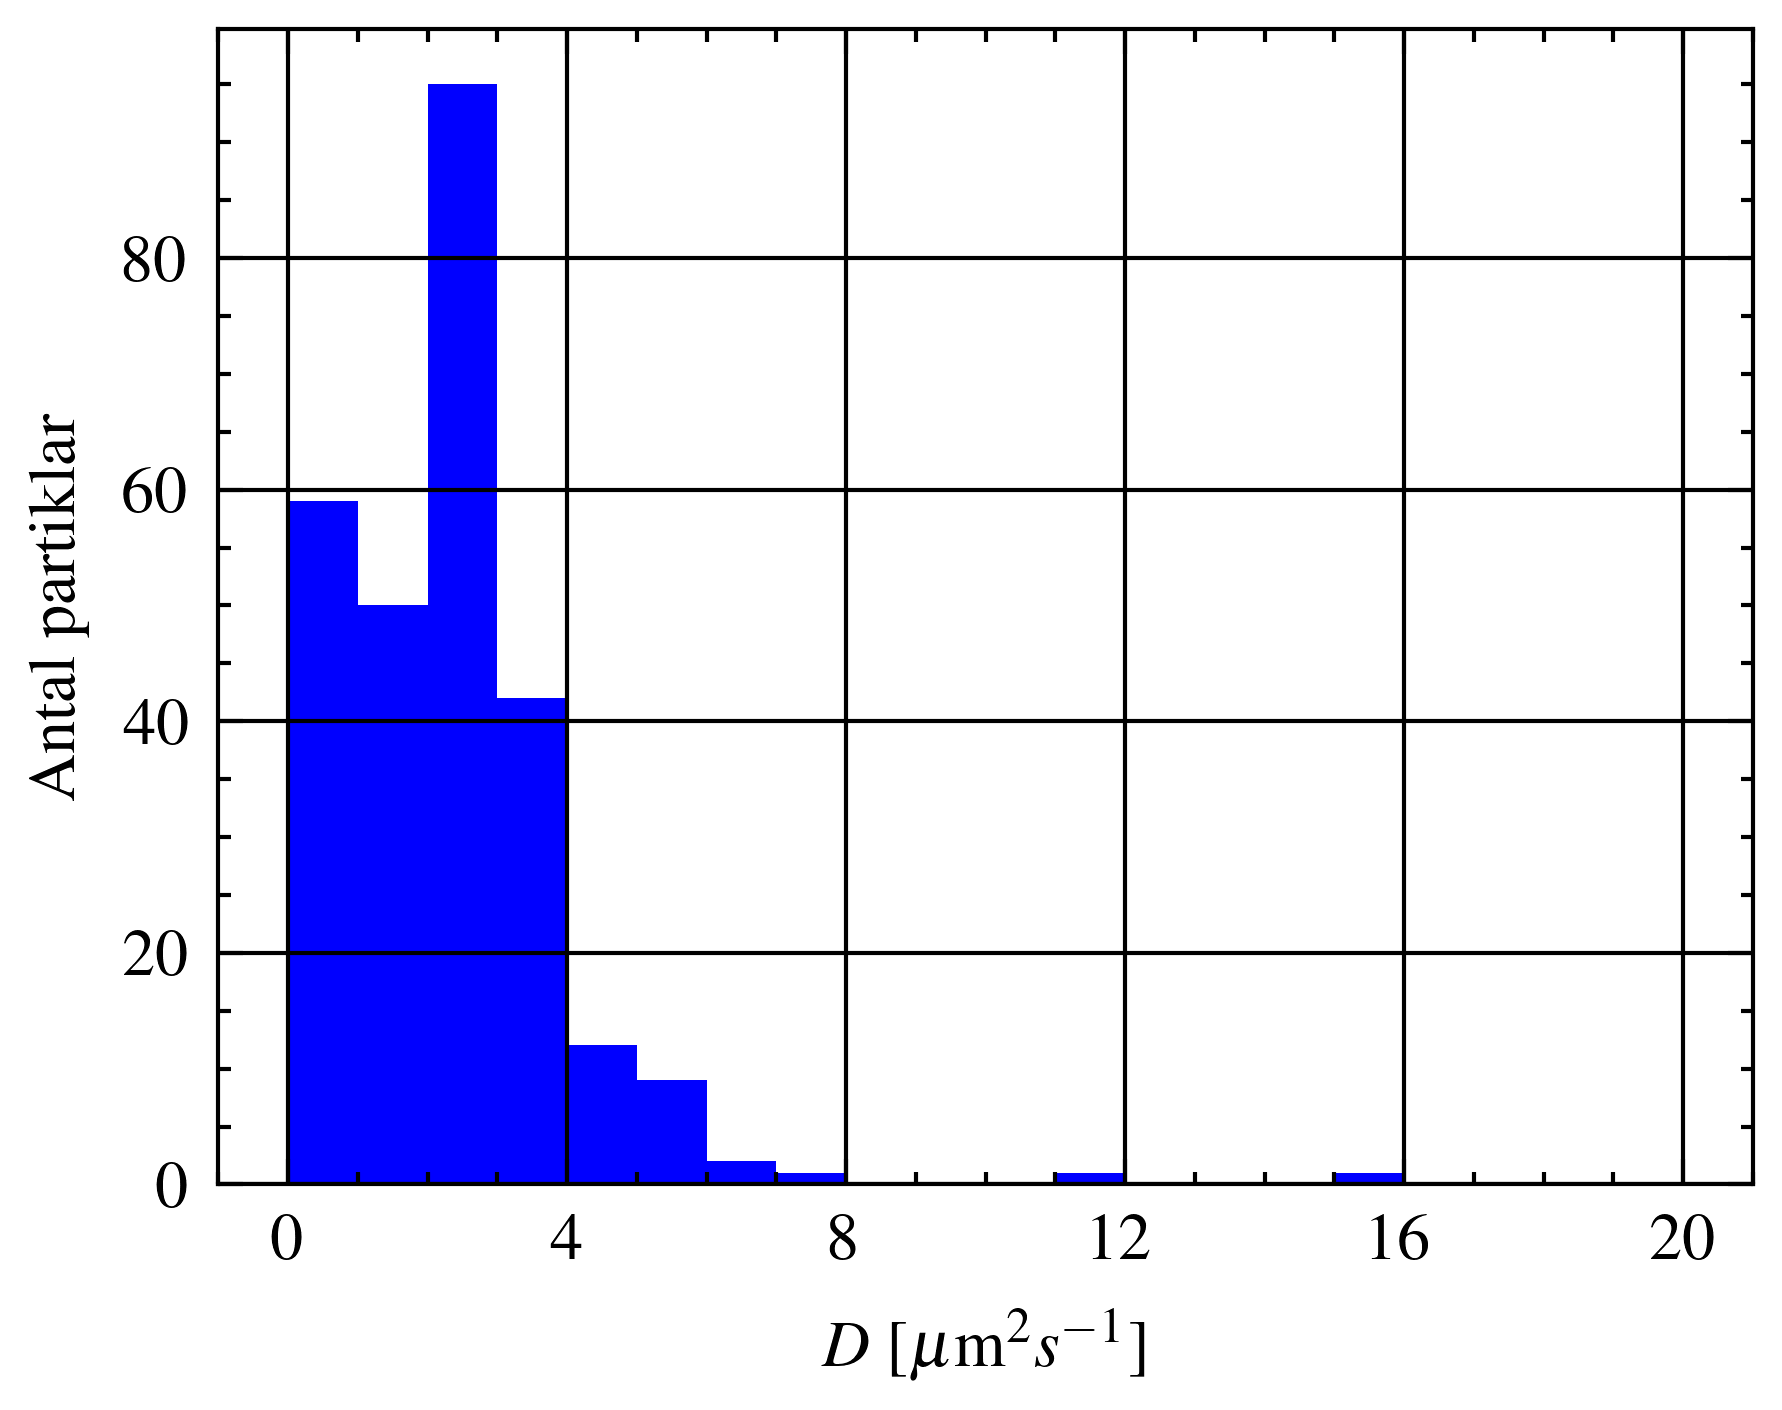

In [35]:
bins = 20
maxrange = 20
D_mu = Diffusiviteter()
print('Medelvärde: ', np.mean(D_mu))
print('Median: ', D_mu[int(len(D_mu)/2)])
xticks = np.linspace(0, maxrange, int(bins/4)+1)
with plt.style.context(["science", 'ieee']):
    plt.grid(color='black')
    plt.hist(D_mu, bins, color='blue', range = (0, maxrange))
    plt.xticks(xticks)
    
    plt.xlabel(r'$D$ [$\mu$m$^2 s^{-1}$]')
    plt.ylabel(r'Antal partiklar')

    plt.show()

In [39]:
def Kovarianser(nodes = M.nodes, traj = M.traj, data_shape = M.data_shape, pixel_size = 65, lagmax = 10):
    covx_matrix = []
    covy_matrix = []
    for (t, c) in traj:
        Nodes = nodes[t]
        covx_particle = []
        covy_particle = []
        for lag in range(lagmax):
            covx = np.array([])
            covy = np.array([])
            for j in range(len(Nodes)-1-lag):
                Tidsstegn = Nodes[j+1][0]-Nodes[j][0]
                Tidsstegnj = Nodes[j+1+lag][0]-Nodes[j+lag][0]

                Steg_xn  = (Nodes[j+1][1]-Nodes[j][1])/Tidsstegn
                Steg_xnj = (Nodes[j+1+lag][1]-Nodes[j+lag][1])/Tidsstegnj

                covx = np.append(covx, (Steg_xn*Steg_xnj)*(data_shape[2]*pixel_size*10**(-3))**2)#/(len(Nodes)-1-lag))

                Steg_yn  = (Nodes[j+1][2]-Nodes[j][2])/Tidsstegn
                Steg_ynj = (Nodes[j+1+lag][2]-Nodes[j+lag][2])/Tidsstegnj

                covy = np.append(covy, (Steg_yn*Steg_ynj)*(data_shape[1]*pixel_size*10**(-3))**2)#/(len(Nodes)-1-lag))
                

            covxapp = np.mean(covx)
            covyapp = np.mean(covy)

            covx_particle.append(covxapp)
            covy_particle.append(covyapp)
        covx_matrix.append(covx_particle)
        covy_matrix.append(covy_particle)
    
    Errorx = np.sqrt(np.sum((np.sum(covx_matrix, axis=0)/len(covx_matrix)-covx_matrix)**2, axis=0)/((len(covx_matrix)-1)*len(covx_matrix)))
    Errory = np.sqrt(np.sum((np.sum(covy_matrix, axis=0)/len(covy_matrix)-covy_matrix)**2, axis=0)/((len(covy_matrix)-1)*len(covx_matrix)))
    
    covxAvg = np.sum(covx_matrix, axis=0)/len(covx_matrix)
    covyAvg = np.sum(covy_matrix, axis=0)/len(covy_matrix)
    return covxAvg, covyAvg, Errorx, Errory

lagmax = 10
delta_t = 1/110
covxAvg, covyAvg, Errorx, Errory = Kovarianser(lagmax=lagmax)

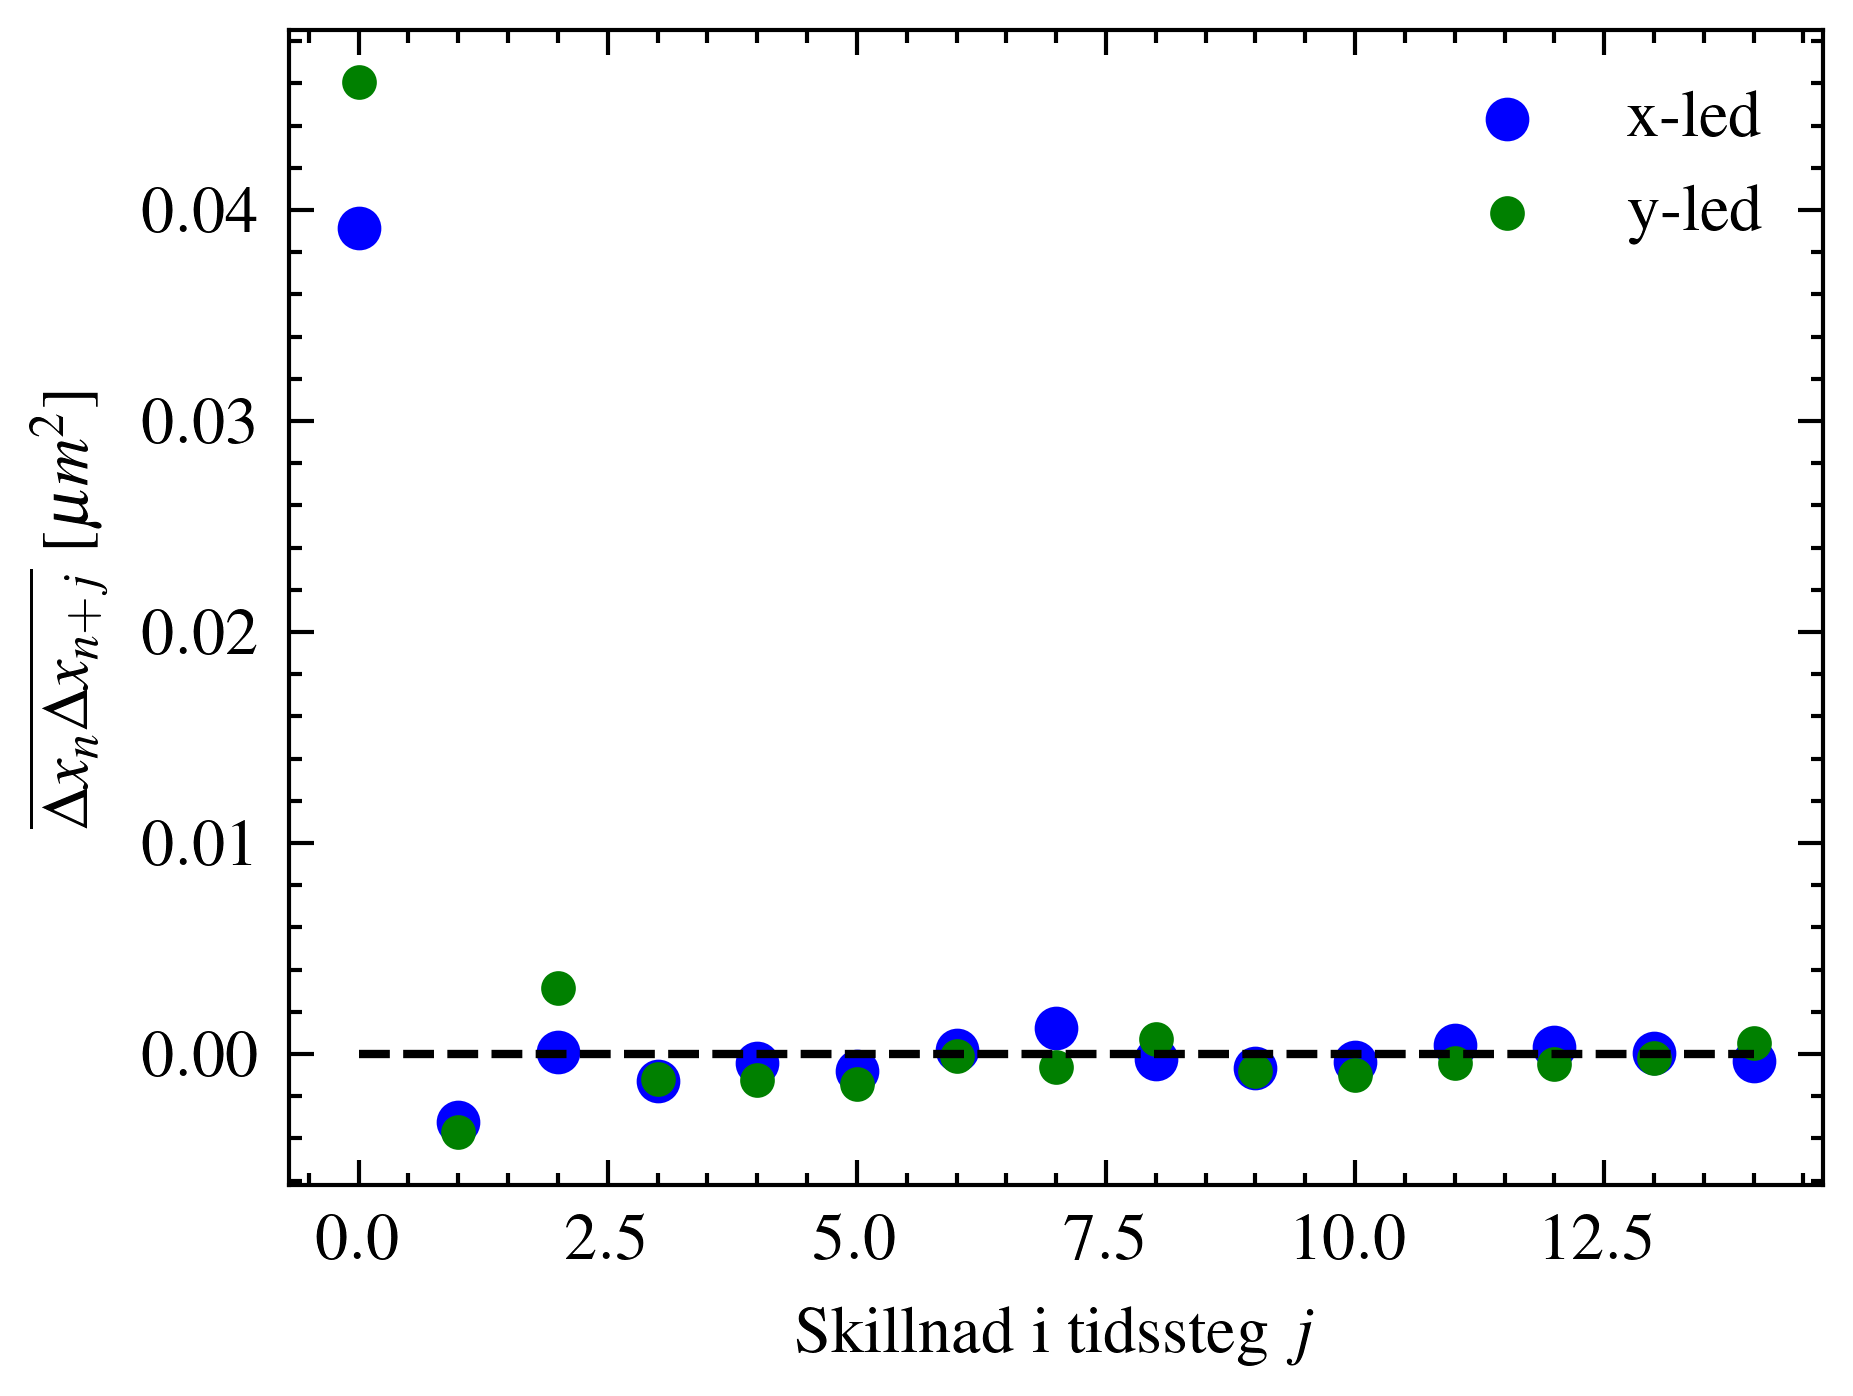

In [40]:

laglist = np.arange(0, lagmax, 1)
theory = np.zeros(len(laglist))
theory[0] = 2*D*delta_t*10**(12)
theory[1] = -0.005

with plt.style.context(["science", 'ieee']):
    
    plt.plot(laglist, theory, color='black', linestyle='--')

    plt.errorbar(laglist, covxAvg, Errorx*2, linestyle='', color='blue', elinewidth=0.5, capthick=0.5, capsize=2, marker='o', markersize=2, label='x-led')
    
    plt.errorbar(laglist, covyAvg, Errory*2, linestyle='', color='orange', elinewidth=0.5, capthick=0.5, capsize=2, marker='o', markersize=2, label='y-led')
    

    plt.xlabel(r'Skillnad i tidssteg $j$')
    plt.ylabel(r'$\overline{\Delta x_n \Delta x_{n+j}}$ [$\mu m^2$]')
    plt.legend()
    
    plt.show()
